In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from  evaluation.core import State
from typing import Dict, List
import datetime
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from copy import deepcopy
import random
from Rushi.PPO.trainer import PPOTrainer
from Rushi.PPO.ml import PPOAgent
from Rushi.PPO.core import EarlyEnvironment, EarlyEnvs
from Rushi.PPO.utils import Logger, makeFeatures, getInvalidActionMask, getStateFeatures, getStockFeatures, interpolatorNotForDay
from evaluation.core import BaseStrategy
from evaluation.constants import HOLD_ACTION,BUY_ACTION,SELL_ACTION
from Rushi.PPO.constants import MAX_HOLDING, MAX_TRADE_TIME_IN_5_MINUTE, MAX_TRADE_TIME_IN_DAYS,ROLLING_WINDOW_SIZE_IN_DAYS, MAX_TRADE_TIME_IN_MINUTE, MODES, minutes_5_in_day, minutes_in_day, ROLLING_WINDOW_SIZE_IN_MINUTE, ROLLING_WINDOW_SIZE_IN_5_MINUTE,end_time_5_minute, end_time_minute
from Rushi.PPO.constants import end_time_minute, end_time_5_minute
from Rushi.PPO.ppoStrategy import PPOStrategy
from evaluation.backTest import BackTest
from tqdm import tqdm

In [2]:
df = pd.read_csv("data/5minute/APOLLOHOSP.csv")
df = interpolatorNotForDay(df= df, mode= "5minute")

total values interpolated = 1230


In [3]:
train_days = ROLLING_WINDOW_SIZE_IN_DAYS + 21
test_days = MAX_TRADE_TIME_IN_DAYS
ppo_config = dict(
    num_envs = 128,
    num_steps = 256,
    observation_dim = 13,
    action_space_dim = 3,
    gamma = .9,
    num_mini_batches = 4,
    update_epochs = 4,
    clip_coef = .2,
    entropy_coef = .01,
    value_coef = .5,
    max_grad_norm = .5
)
print(train_days, test_days)

31 3


In [4]:
class RollingTrain:
    def __init__(self,df,train_days, test_days, ppo_config,device,save_dir,mode,agent = None, updates = 1000):
        self.df = df
        self.train_days = train_days
        self.test_days = test_days
        self.ppo_config = ppo_config
        self.device = device
        self.save_dir = save_dir
        self.roll = 1
        if agent == None:
            self.agent = PPOAgent(lstm_hidden_size= 128,lstm_input_size= ppo_config["observation_dim"], layers= 2, output_dim= ppo_config["action_space_dim"])
        else:
            self.agent = agent
        
        self.agent.to(self.device)

        assert mode in MODES
        self.mode = mode
        unit = None
        if mode == "5minute":
            unit = minutes_5_in_day
        elif(mode == "minute"):
            unit = minutes_in_day
        else:
            unit = 1
        self.unit = unit

        self.train_indices = [0,self.train_days*unit -1]
        self.test_indices = [self.train_days*unit, self.train_days*unit + self.test_days*unit  - 1]
        self.updates = updates

    def _rollIndices(self):
        self.roll += 1
        self.train_indices[0] += self.test_days*self.unit
        self.train_indices[1] += self.test_days*self.unit
        self.test_indices[0] += self.test_days*self.unit
        self.test_indices[1] += self.test_days*self.unit

    
    def getTrainEnvs(self, linspace = [1,1]):
        envs = []
        for _ in range(self.ppo_config["num_envs"]):
            envs.append(EarlyEnvironment(df = df.iloc[self.train_indices[0]:self.train_indices[1] + 1], mode= self.mode,linspace= linspace))
        early_envs = EarlyEnvs(early_environments= envs)
        return early_envs
    
    
    def evalRoll(self):
        ppo_strategy = PPOStrategy(df= df,mode= self.mode, agent= self.agent, device= self.device)
        back_test = BackTest(data= df, strategy= ppo_strategy, initial_cash= 100000, commision= .1, mode= "multi", short= False)
        limits = [self.test_indices[0],self.test_indices[1]]
        back_test.runStrategy(limits= limits)
        trades = sum(back_test.log["is_trade_complete"])
        print("num_trades =  {}".format(trades))
        return back_test.cash - back_test.initial_cash


    def save(self, logger : Logger = None):
        path = self.getAgentPath(roll= self.roll)
        self.agent.save(path= path)
        if logger == None:
            return
        logger_path = self.getLoggerPath(roll= self.roll)
        logger.save(path= logger_path)


    def getAgentPath(self,roll):
        return os.path.join(self.save_dir, "agent_roll_{}.pt".format(roll))
    def getLoggerPath(self,roll):
        return os.path.join(self.save_dir, "logger_roll_{}.pt".format(self.roll))

    
    def load(self,roll):
        path = self.getAgentPath(roll= roll)
        self.agent.load(path= path)
        
        logger_path = self.getLoggerPath(roll= roll)
        
        return Logger.load(path= logger_path)

    def trainSingleRoll(self):
        logger = Logger(name= "STONK_ROLL_{}".format(self.roll))
        logger.default_step_size = 1000
        exists = False
        if os.path.exists(self.getAgentPath(roll= self.roll)):
            logger = self.load(roll= self.roll)
            exists = True
        if exists == True:
            return None
        
        first_roll = self.roll == 1
        envs = self.getTrainEnvs(linspace= [1,1] if first_roll == True else [1,3])
        trainer = PPOTrainer(envs= envs, agent= self.agent, ppo_config= ppo_config, device= device, logger= logger)
        num_updates = self.updates if first_roll == True else 100
        print(num_updates)
        trainer.train(num_updates= num_updates, lr= 3e-4)
        return logger

    

    def getRolling(self):
        while self.test_indices[-1] < len(self.df):
            logger = self.trainSingleRoll()
            self.evalRoll()
            if logger != None:
                self.save(logger= logger)
            self._rollIndices()
        


        
        



In [5]:
rolling_train = RollingTrain(df= df, train_days= train_days, test_days= test_days, ppo_config= ppo_config, device= device,
                             save_dir= "Rushi/models_low_features", mode= "5minute", agent= None, updates= 4000
                            )

In [6]:
rolling_train.getRolling()

Ran from 2019-02-13 09:15:00 to 2019-02-15 15:25:00
Initial value = 100000
Final value = 100053.40750000003
num_trades =  10
Ran from 2019-02-18 09:15:00 to 2019-02-20 15:25:00
Initial value = 100000
Final value = 99940.66350000001
num_trades =  5
Ran from 2019-02-21 09:15:00 to 2019-02-25 15:25:00
Initial value = 100000
Final value = 100064.76424999993
num_trades =  20
Ran from 2019-02-26 09:15:00 to 2019-02-28 15:25:00
Initial value = 100000
Final value = 99925.9794
num_trades =  9
Ran from 2019-03-01 09:15:00 to 2019-03-06 15:25:00
Initial value = 100000
Final value = 100000
num_trades =  0
Ran from 2019-03-07 09:15:00 to 2019-03-11 15:25:00
Initial value = 100000
Final value = 100008.90590000001
num_trades =  3
Ran from 2019-03-12 09:15:00 to 2019-03-14 15:25:00
Initial value = 100000
Final value = 99703.8628
num_trades =  4
100
STONK_ROLL_8 ---- 1 metric avg_reward = -0.8524346736047136
STONK_ROLL_8 ---- 1 metric avg_length = 59.765625
STONK_ROLL_8 ---- 1 metric avg_profit = -50.8

KeyboardInterrupt: 

In [7]:
logger : Logger = Logger.load(path= "Rushi/models_low_features/logger_roll_1.pt")
logger.getAllMetricNames()

['pg_loss',
 'value_loss',
 'entropy_loss',
 'avg_reward',
 'avg_length',
 'avg_profit',
 'avg_trades']

Text(0, 0.5, 'trades')

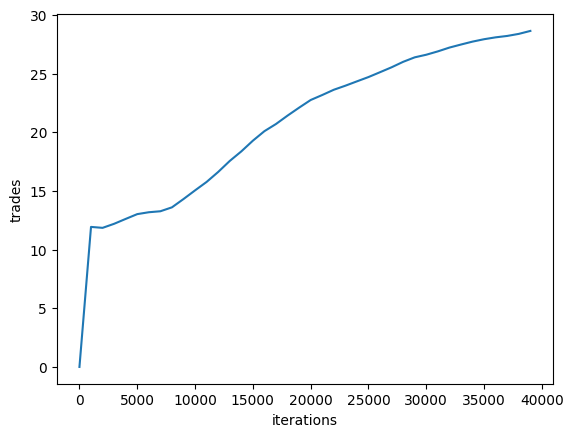

In [15]:
X = np.arange(len(logger.getMetric("avg_trades")))*1000

plt.plot(X,logger.getMetric("avg_trades"))
plt.xlabel("iterations")
plt.ylabel("trades")

Text(0, 0.5, 'profit')

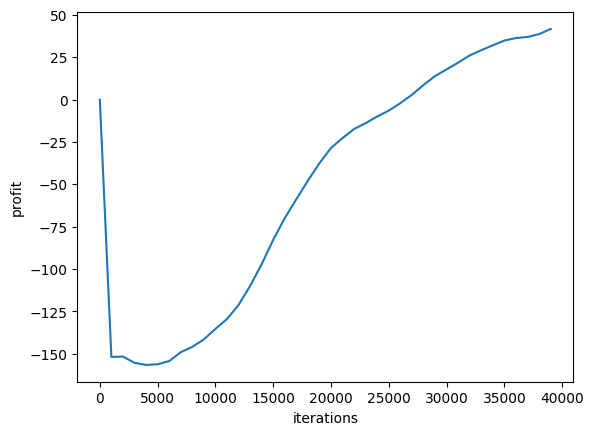

In [14]:
X = np.arange(len(logger.getMetric("avg_profit")))*1000

plt.plot(X,logger.getMetric("avg_profit"))
plt.xlabel("iterations")
plt.ylabel("profit")

In [1]:
envs = rolling_train.getTrainEnvs()

NameError: name 'rolling_train' is not defined

In [2]:
env = envs.early_environments[0]

NameError: name 'envs' is not defined

In [68]:
env.possible_indices

[0,
 75,
 150,
 225,
 300,
 375,
 450,
 525,
 600,
 675,
 750,
 825,
 900,
 975,
 1050,
 1125,
 1200,
 1275,
 1350]

In [69]:
env.reset()


{'next_obs': array([ 0.00444444,  0.00444444,  0.00444444,  0.00444444, -0.23209024,
         1.51242799, -0.1660417 , -0.04260383,  0.25327144,  0.51325301,
         0.0492322 , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ]),
 'invalid_action_mask': [False, False, True]}

In [70]:
env.step(action= HOLD_ACTION)

{'next_obs': array([ 0.00888889,  0.00888889,  0.00888889,  0.00888889, -0.04388625,
        -0.05846165, -0.30123005, -0.11356983,  0.25328075,  0.49975904,
         0.41419828, -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ]),
 'done': 0,
 'reward': 0,
 'invalid_action_mask': [False, False, True]}

In [72]:
env.curr_iterator

{'index': 1126,
 'reward': 0,
 'length': 2,
 'prev_action': 0,
 'profit': 0,
 'trades': 0,
 'state': <evaluation.core.State at 0x75bbb0043550>,
 'prev_invalid_action_mask': [False, False, True]}

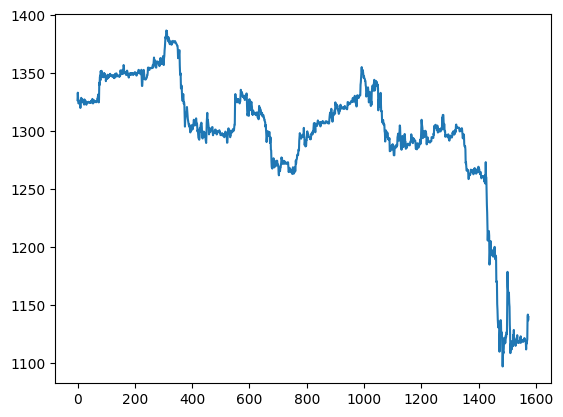

In [71]:
plt.plot(env.data["close"])

In [19]:
env = EarlyEnvironment(df= df.iloc[: ROLLING_WINDOW_SIZE_IN_5_MINUTE  + MAX_TRADE_TIME_IN_5_MINUTE], commision= .1, linspace= [1,1],mode= "5minute")
env.reset()
env.step(action= BUY_ACTION)
#env.step(action= HOLD_ACTION)

{'next_obs': array([ 0.00444444,  0.00444444,  0.00444444,  0.00444444,  2.83559746,
         3.10978014,  2.80067602,  2.79704491,  0.16813337,  0.92402235,
        -0.13463039,  0.2       ,  0.        ,  0.2       ,  0.        ,
         0.2       ,  0.        ]),
 'done': 0,
 'reward': 0,
 'invalid_action_mask': [False, False, True]}

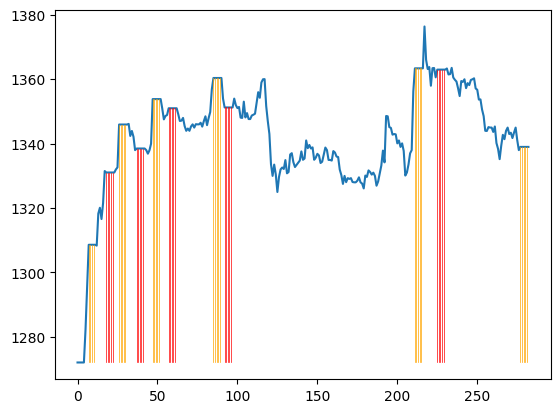

In [23]:
#plt.plot(back_test.log["action"])
X = range(len(back_test.log["closing_price"]))
y_mn = min(back_test.log["closing_price"])
plt.plot(X,back_test.log["closing_price"])

for i,action in enumerate(back_test.log["action"]):
    if action == BUY_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "red",linewidth = .5)
    elif action == SELL_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "orange", linewidth = .5)

In [15]:
back_test.log["action"]

[1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [102]:
curr_agent.save("Rushi/models/agent_roll_1.pt")

In [10]:
trainer.storage["returns"].min()

KeyError: 'returns'

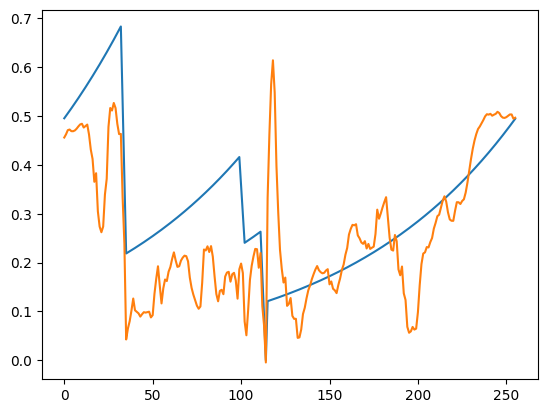

In [104]:
#plt.plot(trainer.storage["advantages"].cpu()[:,42])
plt.plot(trainer.storage["returns"].cpu()[:,42])
plt.plot(trainer.storage["values"].cpu()[:,42])
#plt.plot(trainer.storage["rewards"].cpu()[:,42])
#plt.plot(trainer.storage["dones"].cpu()[15,:])

In [ ]:
back_test.step_trade_counter

0

In [ ]:
back_test.log.keys()

dict_keys(['timestamp', 'money', 'is_trade_complete', 'stock_value', 'total_value', 'action', 'state_length', 'current_pointer', 'step_trade_counter'])

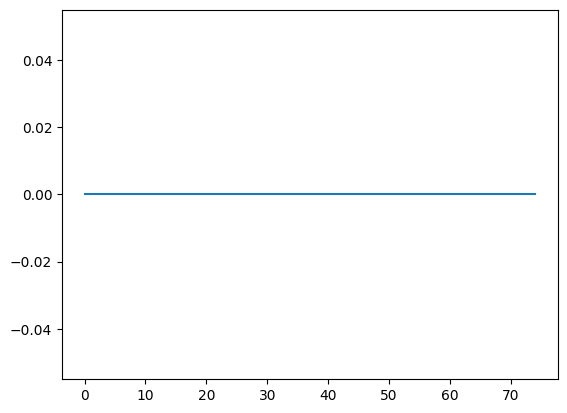

In [ ]:
plt.plot(back_test.log["action"][:100])

In [ ]:
len(back_test.log["action"])

1001

In [ ]:
agent.save(path= "Rushi/models/agent1.pt")

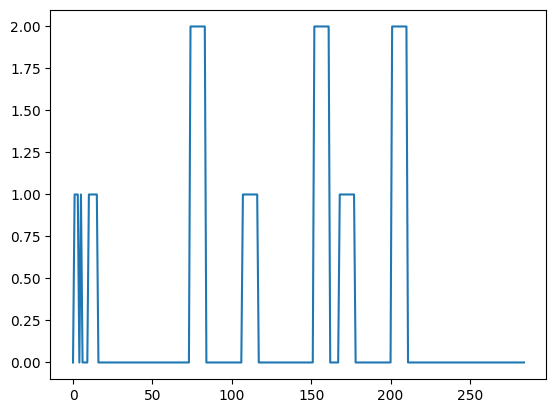

In [ ]:
plt.plot(back_test.log["action"])

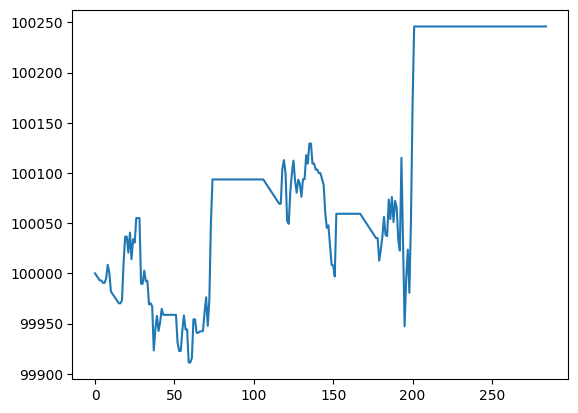

In [ ]:
back_test.plotValue()

In [ ]:
back_test.log["action"][-1]

1

In [ ]:
close = makeFeatures(df= df,mode= "5minute")["close"]
df_close = df.close.values

In [ ]:
len(close), len(df_close)

(3521, 5000)

In [ ]:
start_index = len(df_close) - len(close)

In [ ]:
df_close[start_index]

1272.5

In [ ]:
close[0]

1272.5